In [1]:

from torch_geometric.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import (GINConv,global_add_pool,GATConv,ChebConv,GCNConv)
from torch_geometric.datasets import ZINC
from torch_geometric.utils import to_networkx, to_dense_adj
import geoopt
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from torch_geometric.data import InMemoryDataset

from libs.spect_conv import SpectConv,ML3Layer
from libs.utils import Zinc12KDataset,SpectralDesign,get_n_params
from utils_1 import get_graph_props, make_2d_graph
from torch_geometric.data import Data
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Union

import torch
from torch import Tensor

from torch_geometric.data.collate import collate

from tqdm import tqdm
import argparse


import os
#os.environ["WANDB_MODE"]="dryrun"

/home/math/maskey/anaconda3/envs/glpe/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = SpectralDesign(nmax=37,recfield=2,dv=2,nfreq=7) 

#dataset = Zinc12KDataset(root="graph-task/dataset/ZINC/",pre_transform=transform)
#dataset = Zinc12KDataset(root="graph-task/dataset/ZINC/",pre_transform=transform) #For Ali

########## commented this:
dataset = Zinc12KDataset(root="dataset/ZINC/",pre_transform=transform) #For Sohir

In [3]:
from libs.utils import Model_RGD,training_loop1,get_orthonromal_eigvec


In [72]:
num_eigs = 2
epochs = 1000
device = 'cpu'
p=1

In [97]:
data = dataset[1]
    #Preprocessing

cora_adj = to_dense_adj(data.edge_index)
cora_adj.squeeze_()

A = cora_adj.numpy()
D, L, L_inv, eigval,eigvec = get_graph_props(A,normalize_L='none')

#We transform our eigenvectors into an orthonormalbasis such that it is in the Stiefel manifold

#Just removed for L_2 LPE

hi = get_orthonromal_eigvec(eigval,eigvec)

n= eigval.shape[0]
K = num_eigs
epochs = epochs

# instantiate model
W = torch.tensor(A).float().to(device)
F_ = torch.tensor(hi[:, 0:num_eigs]).float().to(device) #We can use previous outputs weight
m = Model_RGD(F_, p, n, K, ball = geoopt.EuclideanStiefelExact()).to(device) #I think we should not use F_ at initizialization, rather as a forward input so that we can start different init, or just use the reset parameters differently

# Instantiate optimizer
#opt = torch.optim.Adam(params=m.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = geoopt.optim.RiemannianSGD(m.parameters(), lr=1e-2)
#optimizer = geoopt.optim.RiemannianSGD(m.parameters(), lr=1e-2, momentum=0.9)

decayRate = 0.99
my_lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer)#, gamma=decayRate)

scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

#Learn the 1-eigenvector. It is then given by m.weight
start = timer()
losses = training_loop1(m, optimizer,my_lr_scheduler,W, epochs)  
end = timer()
print(end - start, " Second")

m.to('cpu')

1.7331345329293981  Second


Model_RGD(
  (ball): Stiefel(euclidean)(exact) manifold
)

In [92]:
from pygsp import graphs as Graph

In [93]:
gr = Graph.Graph(cora_adj)

In [94]:
gr.set_coordinates()
import pygsp

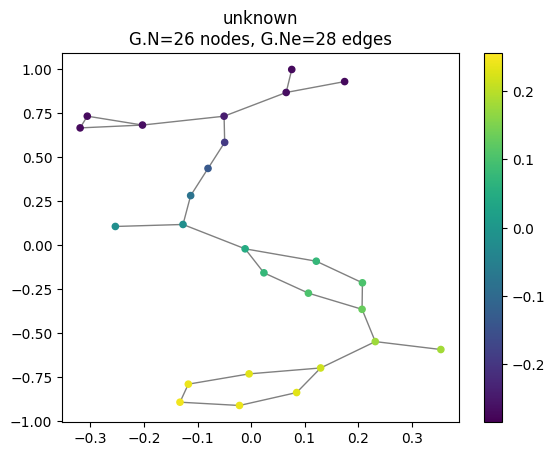

In [95]:
pygsp.plotting.plot_signal(gr, eigvec[:,1],vertex_size=20)

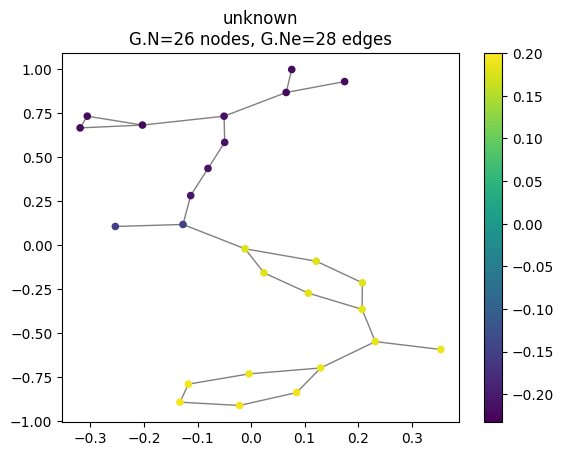

In [96]:
pygsp.plotting.plot_signal(gr, m.to("cpu").weight.detach().numpy()[:,1],vertex_size=20)

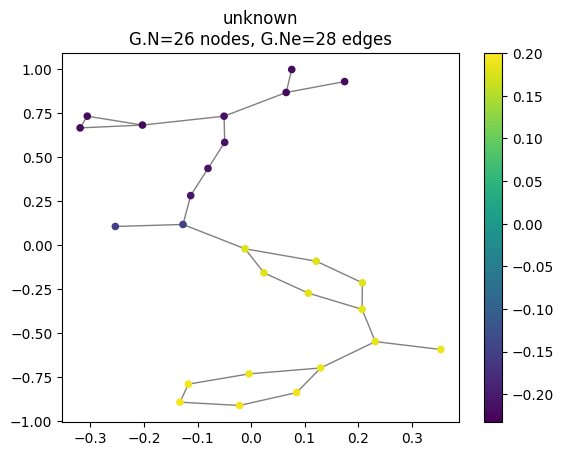

In [98]:
pygsp.plotting.plot_signal(gr, m.to("cpu").weight.detach().numpy()[:,1],vertex_size=20)